Klasyfikacja tekstu przy pomocy metod uczenia maszynowego, na przykładzie ocen produktów spożywczych.

Źródło danych https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews

In [1]:
import numpy as np
import pandas as pd

# Ładujemy dane do dataframe, ograniczamy się do pierwszych 100 000
data = pd.read_csv(filepath_or_buffer='amazon_food_reviews.csv', sep=',', nrows=100000)
df = pd.DataFrame(data)
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [2]:
# Czyszczenie danych usuwam część kolumn,
df.drop(columns=["Id","ProductId", "UserId", "ProfileName", "HelpfulnessNumerator", "HelpfulnessDenominator", "Time", "Summary"], inplace=True)

# Usuwam wiersze z brakującymi danymi
df.replace("unknown", np.NAN, inplace=True)
df.dropna(inplace=True)

df.head()

,Score,Text
0,5,I have bought several of the Vitality canned d...
1,1,Product arrived labeled as Jumbo Salted Peanut...
2,4,This is a confection that has been around a fe...
3,2,If you are looking for the secret ingredient i...
4,5,Great taffy at a great price. There was a wid...


Zamiana recenzji na wektory TF-IDF (ang. TF – term frequency, IDF – inverse document frequency)

In [16]:
corpus = df['Text'].iloc[:10]
print(corpus)

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
5    I got a wild hair for taffy and ordered this f...
6    This saltwater taffy had great flavors and was...
7    This taffy is so good.  It is very soft and ch...
8    Right now I'm mostly just sprouting this so my...
9    This is a very healthy dog food. Good for thei...
Name: Text, dtype: object


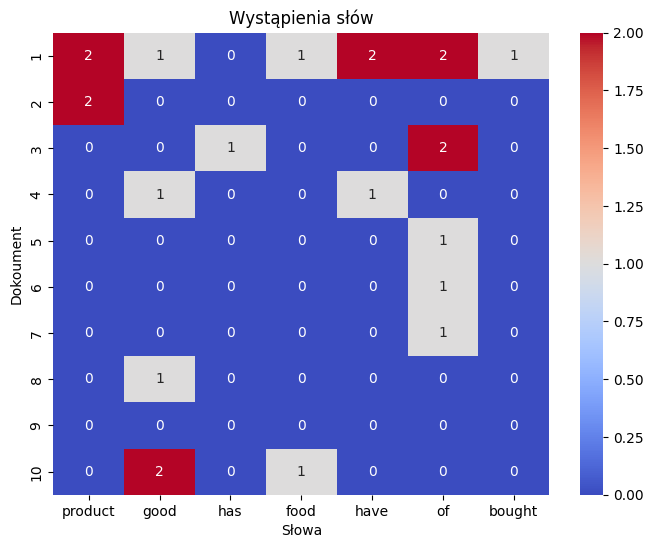

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.pipeline import Pipeline

vocabulary = ['product', 'good', 'has', 'food', 'have', 'of', 'bought']

pipe = Pipeline([('count', CountVectorizer(vocabulary=vocabulary)),('tfid', TfidfTransformer())]).fit(corpus)

# Przykładowa mała macierz częstości słów
word_freq_matrix = pipe['count'].transform(corpus).toarray()

# Używamy heatmapy z biblioteki seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(word_freq_matrix, annot=True, cmap='coolwarm', xticklabels=vocabulary, yticklabels=list(range(1, len(corpus) + 1)))
plt.xlabel('Słowa')
plt.ylabel('Dokoument')
plt.title('Wystąpienia słów')
plt.show()

$$
TF(t, d) = \frac{\text{Liczba wystąpień słowa } t \text{ w dokumencie } d}{\text{Liczba wszystkich słów w dokumencie } d}
$$


Uwaga, w tym wypadku jako 'wszystkie słowa' rozumiemy które występują w słowniku

C:\Users\konra\AppData\Local\Temp\ipykernel_900\3203035235.py:4: RuntimeWarning: invalid value encountered in divide
  normalized_matrix = word_freq_matrix / word_counts_per_doc[:, None]


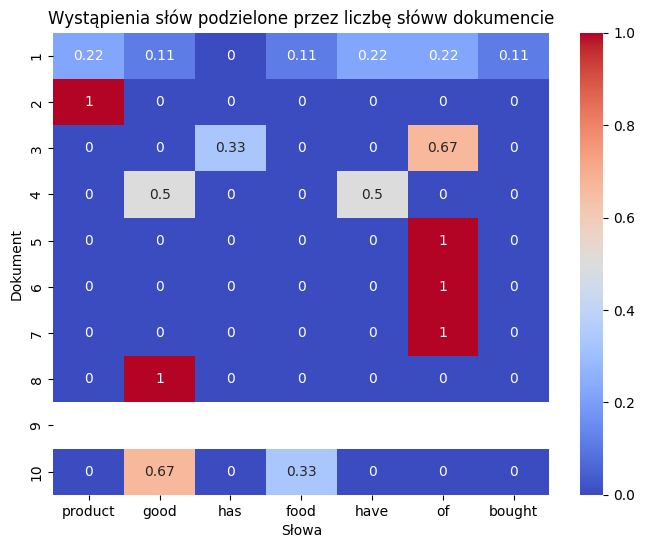

In [28]:
word_counts_per_doc = word_freq_matrix.sum(axis=1)

# Normalizacja macierzy częstości przez liczbę słów w dokumencie
normalized_matrix = word_freq_matrix / word_counts_per_doc[:, None]

# Użyjemy seaborn heatmap do wyświetlenia znormalizowanej macierzy
plt.figure(figsize=(8, 6))
sns.heatmap(normalized_matrix, annot=True, cmap='coolwarm', xticklabels=vocabulary, yticklabels=list(range(1, len(corpus) + 1)))
plt.xlabel('Słowa')
plt.ylabel('Dokument')
plt.title('Wystąpienia słów podzielone przez liczbę słóww dokumencie')
plt.show()

$$
IDF(t, D) = \ln \left( \frac{\text{Liczba wszystkich dokumentów w zbiorze } D + 1}{\text{Liczba dokumentów, w których występuje słowo } t + 1} \right) + 1
$$

In [5]:
idf_values = pipe['tfid'].idf_
idf_values

array([2.29928298, 1.78845736, 2.70474809, 2.29928298])

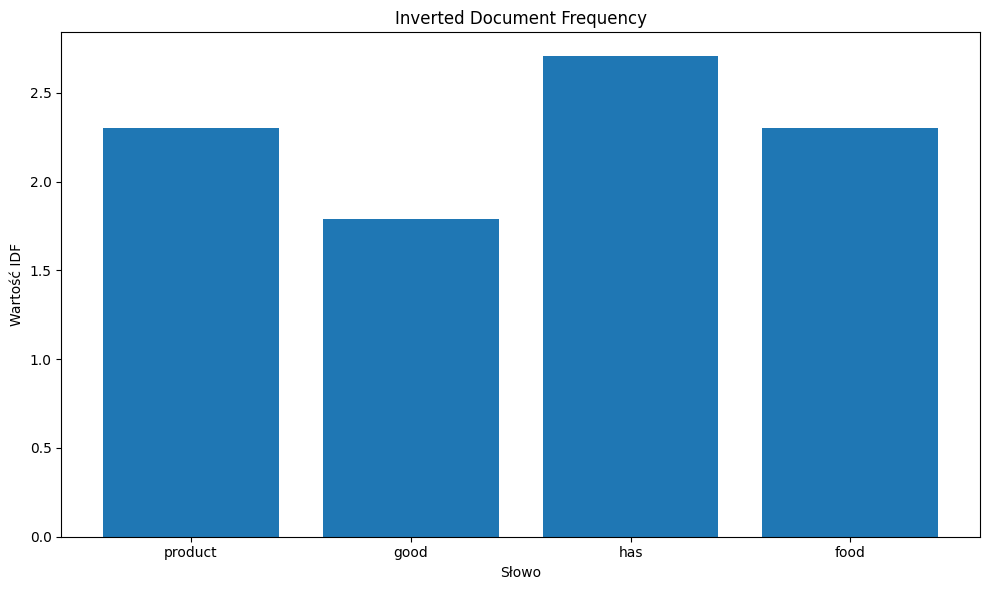

In [6]:

# Konwertowanie wartości IDF do postaci macierzy (w jednym wierszu)
idf_matrix = idf_values.reshape(1, -1)

words_indices = vocabulary
# Tworzenie wykresu słupkowego dla wartości IDF
plt.figure(figsize=(10, 6))
plt.bar(words_indices, idf_values)
plt.xlabel('Słowo')
plt.ylabel('Wartość IDF')
plt.title('Inverted Document Frequency')
plt.xticks(words_indices)  # Ustawienie etykiet dla słów
plt.tight_layout()
plt.show()

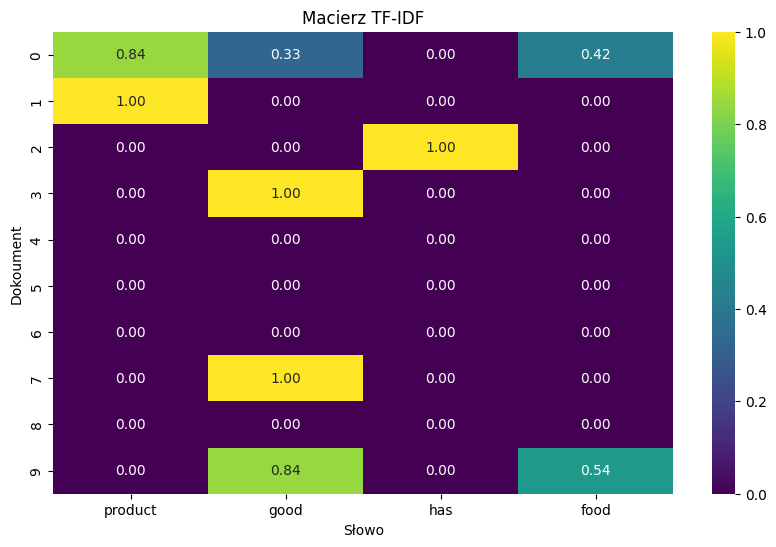

In [7]:

tfidf_matrix = pipe.transform(corpus).toarray()

words_indices = vocabulary
# Tworzenie wykresu słupkowego dla wartości TF-IDF
plt.figure(figsize=(10, 6))
sns.heatmap(tfidf_matrix, cmap='viridis', annot=True, fmt='.2f', xticklabels=words_indices)
plt.title('Macierz TF-IDF')
plt.xlabel('Słowo')
plt.ylabel('Dokoument')
plt.show()

Więcej info:  
https://medium.com/@cmukesh8688/tf-idf-vectorizer-scikit-learn-dbc0244a911a  
https://www.youtube.com/watch?v=vZAXpvHhQow&t=281s

In [30]:
# Wracając no pełnego zbioru danych
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=40000, analyzer='word', lowercase=True)

X = tfidf.fit_transform(df['Text'])
y = df['Score']

X.shape, y.shape

((100000, 40000), (100000,))

In [31]:
tfidf.vocabulary_

{'have': 17903,
 'bought': 7101,
 'several': 30409,
 'of': 24301,
 'the': 35339,
 'vitality': 37987,
 'canned': 8457,
 'dog': 13350,
 'food': 15894,
 'products': 26946,
 'and': 3265,
 'found': 16041,
 'them': 35354,
 'all': 2893,
 'to': 35726,
 'be': 5668,
 'good': 17012,
 'quality': 27423,
 'product': 26940,
 'looks': 21381,
 'more': 23054,
 'like': 21087,
 'stew': 33387,
 'than': 35317,
 'processed': 26911,
 'meat': 22246,
 'it': 19733,
 'smells': 31696,
 'better': 6172,
 'my': 23343,
 'labrador': 20596,
 'is': 19704,
 'finicky': 15485,
 'she': 30566,
 'appreciates': 3523,
 'this': 35460,
 'most': 23105,
 'arrived': 3659,
 'labeled': 20579,
 'as': 3710,
 'jumbo': 20071,
 'salted': 29342,
 'peanuts': 25430,
 'were': 38663,
 'actually': 2116,
 'small': 31649,
 'sized': 31288,
 'unsalted': 36966,
 'not': 23923,
 'sure': 34448,
 'if': 18822,
 'was': 38431,
 'an': 3237,
 'error': 14495,
 'or': 24555,
 'vendor': 37631,
 'intended': 19474,
 'represent': 28438,
 'confection': 10899,
 'that':

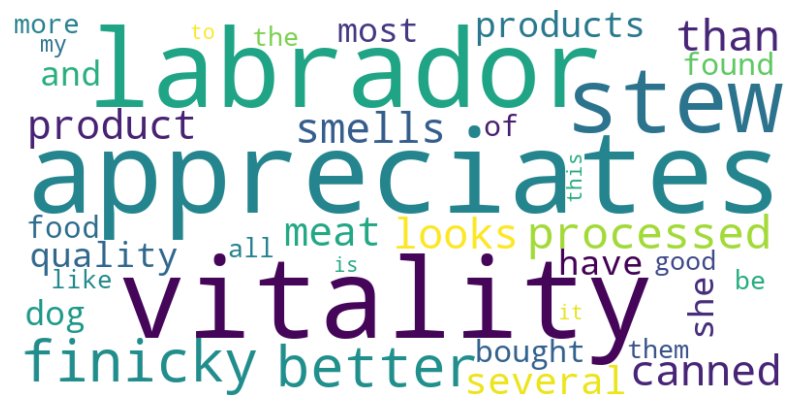

In [36]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Pobieramy nazwy cech z TF-IDF vectorizer
feature_names = tfidf.get_feature_names_out()

# Tworzymy słownik mapujący nazwy cech do wartości TF-IDF
word_scores = dict(zip(feature_names, X[0].toarray()[0]))
# Tworzenie chmury słów
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_scores)

# Tworzenie wykresu z chmurą słów
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [37]:
from sklearn.model_selection import train_test_split

# Następnie zeestawy dziele na treningowy zbiór i zbiór testowy

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0, shuffle=True)
X_train.shape

(90000, 40000)

Support Vector Classifiers  
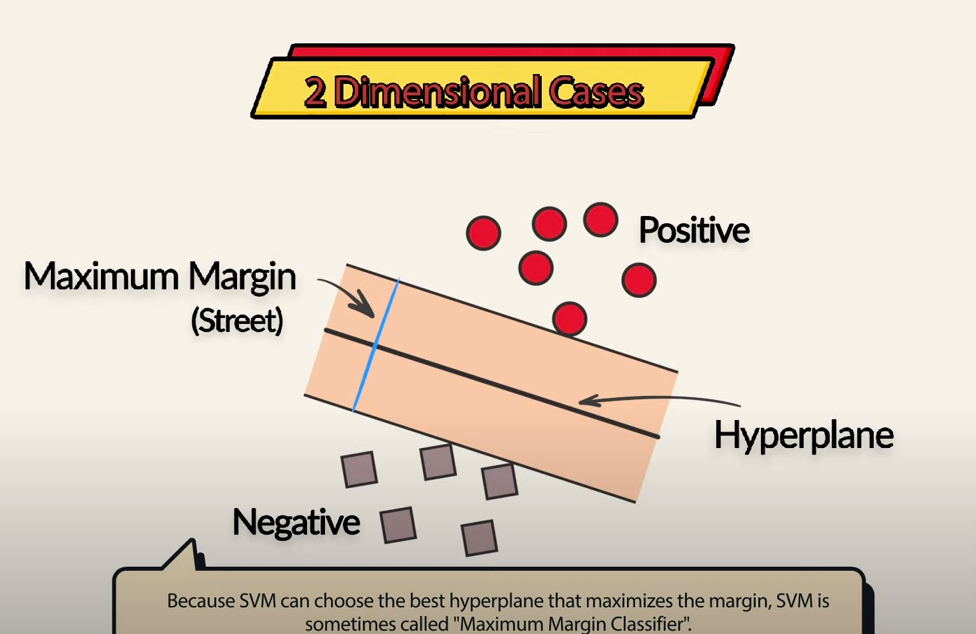  
Źródło: https://www.youtube.com/watch?v=ny1iZ5A8ilA

In [41]:
# Trening z LinearSVC
from sklearn.svm import LinearSVC
clf = LinearSVC()
clf.fit(X_train, y_train)

c:\Projects_programming\courses\text_interpretations\env\lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


LinearSVC()

In [42]:
from sklearn.metrics import classification_report
y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           1       0.67      0.65      0.66       911
           2       0.47      0.24      0.31       577
           3       0.47      0.35      0.40       752
           4       0.47      0.26      0.34      1486
           5       0.79      0.94      0.86      6274

    accuracy                           0.73     10000
   macro avg       0.57      0.49      0.51     10000
weighted avg       0.69      0.73      0.70     10000



Co to za liczby powyżej?  
Precision (Precyzja): Proporcja poprawnie przewidzianych pozytywnych przypadków spośród wszystkich pozytywnych przypadków przewidzianych przez model. 
$$
\text{Precision} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Positives (FP)}}
$$

Recall (Czułość): Proporcja poprawnie przewidzianych pozytywnych przypadków spośród wszystkich rzeczywiście występujących pozytywnych przypadków w danych.
$$
\text{Recall} = \frac{\text{True Positives (TP)}}{\text{True Positives (TP)} + \text{False Negatives (FN)}}
$$

F1-Score: To średnia harmoniczna precyzji i czułości. Jest miarą równowagi między precyzją a czułością.
$$
\text{F1-score} = 2 \times \frac{\text{Precision} \times \text{Recall}}{\text{Precision} + \text{Recall}}
$$

Support (Wsparcie): Liczba wystąpień każdej z klas w zbiorze danych testowych.


In [49]:
# Przetestujmy sobie nasz model
my_sample_food_review = "ok"
predicted_rating = clf.predict(tfidf.transform([my_sample_food_review]))[0]
print("Predicted rating: ", predicted_rating)

Predicted rating:  3


In [ ]:
from sklearn.tree import DecisionTreeClassifier

clf_dec = DecisionTreeClassifier(random_state=0)
clf_dec.fit(X_train, y_train)

In [ ]:
y_pred = clf_dec.predict(X_test)
print(classification_report(y_test, y_pred))

In [ ]:
from sklearn.neural_network import MLPClassifier
clf_neur = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(5, 2))
clf_neur.fit(X_train, y_train)

In [ ]:
y_pred = clf_neur.predict(X_test)
print(classification_report(y_test, y_pred))